# Testing scripts, retrieving weather data

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API key
api_key = os.getenv("API_KEY")

In [2]:
import requests
from datetime import date, datetime, timedelta
import time

In [3]:
# Testing geocoding to get the latlong data of a city
def get_city_coordinates(city, api_key):
    url = f"http://api.openweathermap.org/geo/1.0/direct?q={city}&limit=1&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if data:
            lat = data[0]['lat']
            lon = data[0]['lon']
            return lat, lon
        else:
            print(f"City '{city}' not found.")
            return None, None
    else:
        print("Error fetching coordinates:", response.status_code)
        return None, None

city = "Surabaya"
# city = "Jakarta"
lat, lon = get_city_coordinates(city, api_key)
print(lat)
print(lon)

-7.2459717
112.7378266


In [4]:
# Function to fetch weather data
def get_weather(lat, lon, part, api_key):
    url = f"https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude={part}&appid={api_key}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Error:", response.status_code)
        return None

# Function to display weather data
def display_weather(data):
    if data:
        temp = data["current"]["temp"]
        weather = data["current"]["weather"][0]["description"]
        humidity = data["current"]["humidity"]
        wind_speed = data["current"]["wind_speed"]

        # print(f"Weather in {city}:")
        print(f"Temperature: {temp}°C")
        print(f"Condition: {weather}")
        print(f"Humidity: {humidity}%")
        print(f"Wind Speed: {wind_speed} m/s")
    else:
        print("No data to display.")

# Main program
if __name__ == "__main__":
    city_name = input("Enter the city name: ")
    part = 'minutely,hourly'
    weather_data = get_weather(lat, lon, part, api_key)
    display_weather(weather_data)

Temperature: 29.25°C
Condition: overcast clouds
Humidity: 70%
Wind Speed: 5.41 m/s


In [19]:
def get_historical_weather(lat, lon, api_key, days=30):
    """Fetch historical weather data for the last 'days' days."""
    base_url = base_url = f"https://api.openweathermap.org/data/3.0/onecall/timemachine"
    weather_data = []

    for i in range(days):
        # Calculate the timestamp for each day
        ts_d_min_i = datetime.utcnow() - timedelta(days=i+1) # Timestamp of day minus (i+1)
        timestamp = int(ts_d_min_i.timestamp())
        params = {
            "lat": lat,
            "lon": lon,
            "dt": timestamp,
            "appid": api_key,
            "units": "metric" # Optional: Metric units for temperature
        }

        # Make the API call
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            day_data = response.json()
            weather_data.append({
                "timestamp_utc": timestamp,
                "timezone_offset": day_data["timezone_offset"], # offset to be added to timestamp_utc to convert it to GMT+7
                "date_utc": datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d'),
                "weather": day_data["data"][0]["weather"][0]["main"],
                "description": day_data["data"][0]["weather"][0]["description"],
                "temperature": day_data["data"][0]["temp"],
                "pressure": day_data["data"][0]["pressure"],
                "humidity": day_data["data"][0]["humidity"],
                "dew_point": day_data["data"][0]["dew_point"],
                "wind_speed": day_data["data"][0]["wind_speed"]
            })
        else:
            print(f"Error fetching weather data for day {i+1}: {response.status_code}")
            break

        # Avoid hitting rate limits
        time.sleep(1)

    return weather_data

In [22]:
import csv

# Save the weather data to a CSV file
def save_to_csv(data, city_name):
    filename = "{}_weather.csv".format(city_name.lower())
    with open(filename, mode="w", newline="") as file:
        writer = csv.DictWriter(
            file,
            fieldnames=[
                "timestamp_utc",
                "timezone_offset",
                "date_utc",
                "weather",
                "description",
                "temperature",
                "pressure",
                "humidity",
                "dew_point",
                "wind_speed"
                ])
        writer.writeheader()
        writer.writerows(data)
    print(f"Weather data saved to {filename}")


In [23]:
def main():
    # Change to your desired city
    city_name = "Surabaya"
    # city_name = input("Enter the city name: ")
    
    # Number of past days to retrieve
    days = 30

    # Step 1: Get city coordinates
    lat, lon = get_city_coordinates(city_name, api_key)
    if lat is None or lon is None:
        return

    # Step 2: Fetch historical weather data
    weather_data = get_historical_weather(lat, lon, api_key, days)

    # Step 3: Display or process the data
    for day in weather_data:
        timestamp = day["timestamp_utc"]
        date = day["date_utc"]
        temp = day["temperature"]
        weather = day["weather"]
        weather_desc = day["description"]
        print(f"Date: {date}, Time: {timestamp}, Temp: {temp}°C, Weather: {weather}, {weather_desc}")

    # Step 4: Store the weather data to a CSV file
    save_to_csv(weather_data, city_name)

if __name__ == "__main__":
    main()

Date: 2025-01-28, Time: 1738102821, Temp: 24.7°C, Weather: Clouds, overcast clouds
Date: 2025-01-27, Time: 1738016422, Temp: 23.9°C, Weather: Haze, haze
Date: 2025-01-26, Time: 1737930024, Temp: 24.63°C, Weather: Rain, light rain
Date: 2025-01-25, Time: 1737843625, Temp: 25.36°C, Weather: Clouds, overcast clouds
Date: 2025-01-24, Time: 1737757227, Temp: 23.91°C, Weather: Mist, mist
Date: 2025-01-23, Time: 1737670828, Temp: 24.07°C, Weather: Mist, mist
Date: 2025-01-22, Time: 1737584430, Temp: 24.35°C, Weather: Mist, mist
Date: 2025-01-21, Time: 1737498031, Temp: 24.81°C, Weather: Clouds, few clouds
Date: 2025-01-20, Time: 1737411633, Temp: 23.29°C, Weather: Rain, light rain
Date: 2025-01-19, Time: 1737325234, Temp: 24.6°C, Weather: Rain, light rain
Date: 2025-01-18, Time: 1737238836, Temp: 24.09°C, Weather: Haze, haze
Date: 2025-01-17, Time: 1737152437, Temp: 24.1°C, Weather: Haze, haze
Date: 2025-01-16, Time: 1737066039, Temp: 24.53°C, Weather: Haze, haze
Date: 2025-01-15, Time: 17369

# EDA

In [26]:
# Load the CSV data
filename = "surabaya_weather.csv"  # Replace with your actual CSV file
weather_data = pd.read_csv(filename)

# Convert date to a datetime object for better handling
weather_data['date_utc'] = pd.to_datetime(weather_data['date_utc'])

In [27]:
weather_data.head()

,timestamp_utc,timezone_offset,date_utc,weather,description,temperature,pressure,humidity,dew_point,wind_speed
0,1738102821,25200,2025-01-28,Clouds,overcast clouds,24.70,1009,90,22.95,2.48
1,1738016422,25200,2025-01-27,Haze,haze,23.90,1007,95,23.05,2.06
2,1737930024,25200,2025-01-26,Rain,light rain,24.63,1006,92,23.24,1.95
3,1737843625,25200,2025-01-25,Clouds,overcast clouds,25.36,1008,89,23.41,1.03
4,1737757227,25200,2025-01-24,Mist,mist,23.91,1008,95,23.06,0.51


In [28]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   timestamp_utc    30 non-null     int64         
 1   timezone_offset  30 non-null     int64         
 2   date_utc         30 non-null     datetime64[ns]
 3   weather          30 non-null     object        
 4   description      30 non-null     object        
 5   temperature      30 non-null     float64       
 6   pressure         30 non-null     int64         
 7   humidity         30 non-null     int64         
 8   dew_point        30 non-null     float64       
 9   wind_speed       30 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 2.5+ KB


In [33]:
# Test
weather_data["timestamp_utc"].head()
weather_data["timestamp_utc"].head().apply(lambda x: datetime.fromtimestamp(x))


0   2025-01-29 05:20:21
1   2025-01-28 05:20:22
2   2025-01-27 05:20:24
3   2025-01-26 05:20:25
4   2025-01-25 05:20:27
Name: timestamp_utc, dtype: datetime64[ns]

In [35]:
weather_data["timestamp_wib"] = weather_data["timestamp_utc"] + weather_data["timezone_offset"]
weather_data["timestamp_wib"] = weather_data["timestamp_wib"].apply(lambda x: datetime.fromtimestamp(x))
weather_data["timestamp_wib"].head()

0   2025-01-29 12:20:21
1   2025-01-28 12:20:22
2   2025-01-27 12:20:24
3   2025-01-26 12:20:25
4   2025-01-25 12:20:27
Name: timestamp_wib, dtype: datetime64[ns]

In [44]:
weather_data["date_wib"] = weather_data["timestamp_wib"].dt.normalize()
weather_data["date_wib"].head()

0   2025-01-29
1   2025-01-28
2   2025-01-27
3   2025-01-26
4   2025-01-25
Name: date_wib, dtype: datetime64[ns]

In [45]:
weather_data.head()

,timestamp_utc,timezone_offset,date_utc,weather,description,temperature,pressure,humidity,dew_point,wind_speed,timestamp_wib,date_wib
0,1738102821,25200,2025-01-28,Clouds,overcast clouds,24.70,1009,90,22.95,2.48,2025-01-29 12:20:21,2025-01-29
1,1738016422,25200,2025-01-27,Haze,haze,23.90,1007,95,23.05,2.06,2025-01-28 12:20:22,2025-01-28
2,1737930024,25200,2025-01-26,Rain,light rain,24.63,1006,92,23.24,1.95,2025-01-27 12:20:24,2025-01-27
3,1737843625,25200,2025-01-25,Clouds,overcast clouds,25.36,1008,89,23.41,1.03,2025-01-26 12:20:25,2025-01-26
4,1737757227,25200,2025-01-24,Mist,mist,23.91,1008,95,23.06,0.51,2025-01-25 12:20:27,2025-01-25


# Testing Viz

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Line chart: Temperature

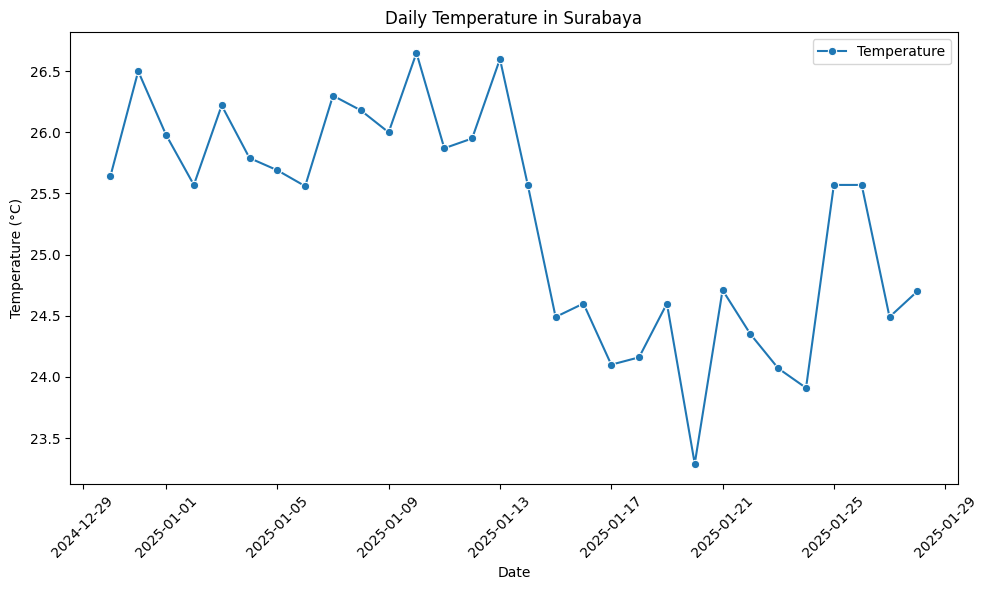

In [10]:
# Load the CSV data
filename = "surabaya_weather.csv"  # Replace with your actual CSV file
weather_data = pd.read_csv(filename)

# Convert date to a datetime object for better handling
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Plot temperature trends
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='temperature', data=weather_data, marker='o', label='Temperature')
plt.title('Daily Temperature in Surabaya')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


## Interactive Viz

In [68]:
import plotly.express as px

In [69]:
# Interactive temperature plot
fig = px.line(weather_data, x='date', y='temperature', title='Daily Temperature in Surabaya',
              labels={'temperature': 'Temperature (°C)', 'date': 'Date'})
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed